1 Sampling via Inverse Transform Technique

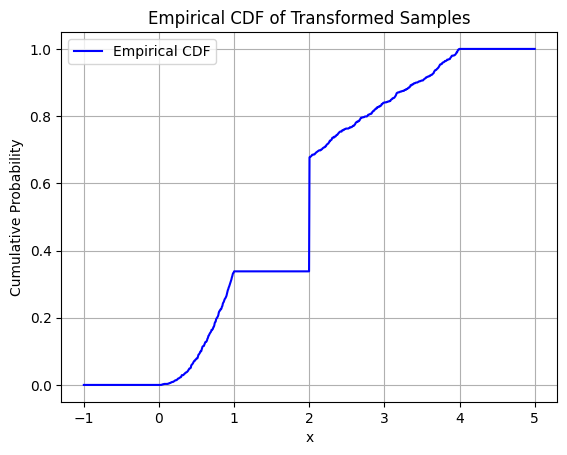

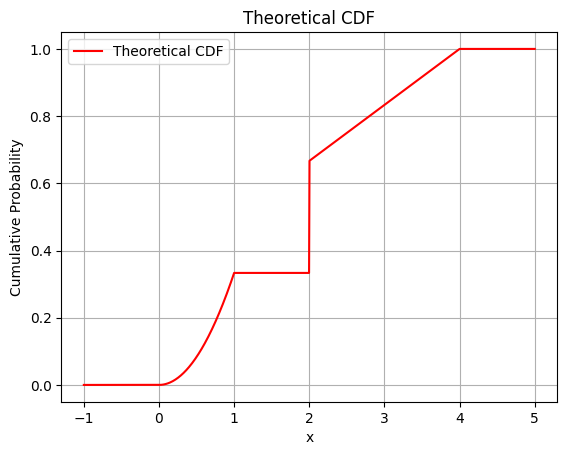

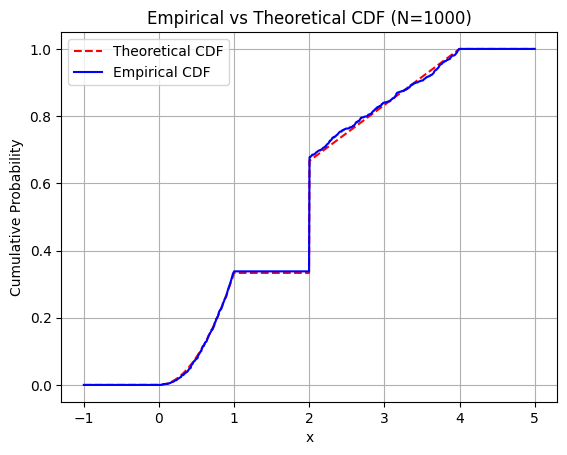

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
np.random.seed(100)

# Generating 1000 uniform samples
N = 1000
array_samples_uniform = np.random.uniform(0, 1, N)

# inverse function F^(-1)
def inverse_transform(u):
    if 0 <= u < 1/3:
        return np.sqrt(3 * u)
    elif 1/3 <= u < 2/3:
        return 2
    elif 2/3 <= u <= 1:
        return 6 * u - 2
    return 4  # fallback, though it should not happen if u in [0,1]

# Computing empirical CDF
def empirical_cdf(data, x_values):
    return np.array([np.sum(data <= x) / len(data) for x in x_values])

# Define x-values and theoretical CDF
x_vals = np.linspace(-1, 5, 1000)

def theoretical_cdf(x):
    if x < 0:
        return 0
    elif 0 <= x < 1:
        return x**2 / 3
    elif 1 <= x < 2:
        return 1/3
    elif 2 <= x < 4:
        return (x + 2) / 6
    else:
        return 1

theoretical_cdf_vals = np.array([theoretical_cdf(x) for x in x_vals])

# Plotting empirical CDF (static for full sample)
array_samples_custom = np.array([inverse_transform(u) for u in array_samples_uniform])
empirical_cdf_vals = empirical_cdf(array_samples_custom, x_vals)

fig1, ax1 = plt.subplots()
ax1.plot(x_vals, empirical_cdf_vals, label="Empirical CDF", color="blue")
ax1.set_title("Empirical CDF of Transformed Samples")
ax1.set_xlabel("x")
ax1.set_ylabel("Cumulative Probability")
ax1.legend()
plt.grid(True)
plt.show()

# Plotting theoretical CDF
fig2, ax2 = plt.subplots()
ax2.plot(x_vals, theoretical_cdf_vals, label="Theoretical CDF", color="red")
ax2.set_title("Theoretical CDF")
ax2.set_xlabel("x")
ax2.set_ylabel("Cumulative Probability")
ax2.legend()
plt.grid(True)
plt.show()

# Animation (Empirical CDF as N increases with random subset)
fig3, ax3 = plt.subplots()
ax3.set_title("Empirical vs Theoretical CDF ")
ax3.set_xlabel("x")
ax3.set_ylabel("Cumulative Probability")

# Plotting fixed theoretical CDF
ax3.plot(x_vals, theoretical_cdf_vals, color='red', linestyle='--', label="Theoretical CDF")

# Initialize an empty line for empirical CDF
line, = ax3.plot([], [], color='blue', label="Empirical CDF")
ax3.legend()

def init():
    line.set_data([], [])
    return line,

def update(n):
    # Randomly choose n samples from the 1000 uniform samples
    random_indices = np.random.choice(N, size=n, replace=False)
    random_uniform_subset = array_samples_uniform[random_indices]

    # Apply inverse transform to get the custom distributed samples
    sample_subset = np.array([inverse_transform(u) for u in random_uniform_subset])

    # Compute empirical CDF
    y_vals = empirical_cdf(sample_subset, x_vals)
    line.set_data(x_vals, y_vals)
    ax3.set_title(f"Empirical vs Theoretical CDF (N={n})")
    return line,

# Create animation
ani = animation.FuncAnimation(
    fig3, update, frames=range(10, N+1, 2),
    init_func=init, interval=100, blit=True
)

plt.grid(True)
ani.save("empirical_cdf_animation.mp4", writer='ffmpeg', fps=20)


2 Wordle: A Game in Probability

Total words loaded: 3103


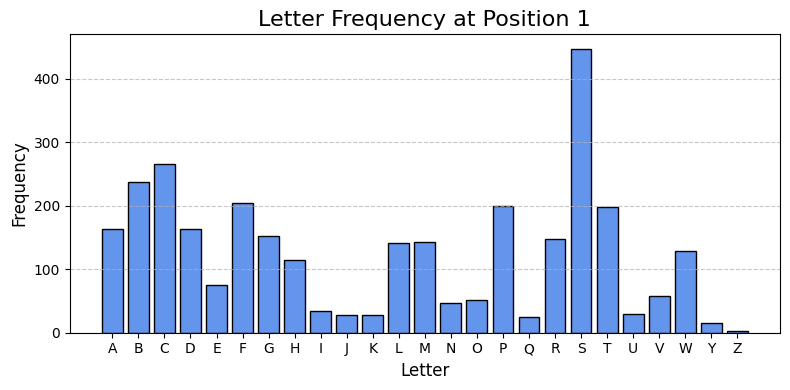

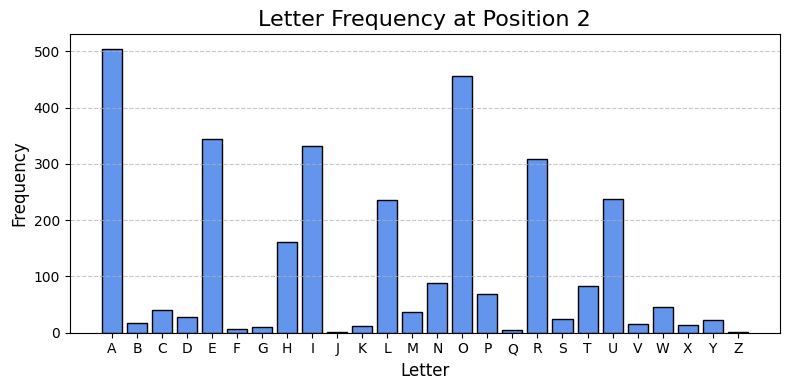

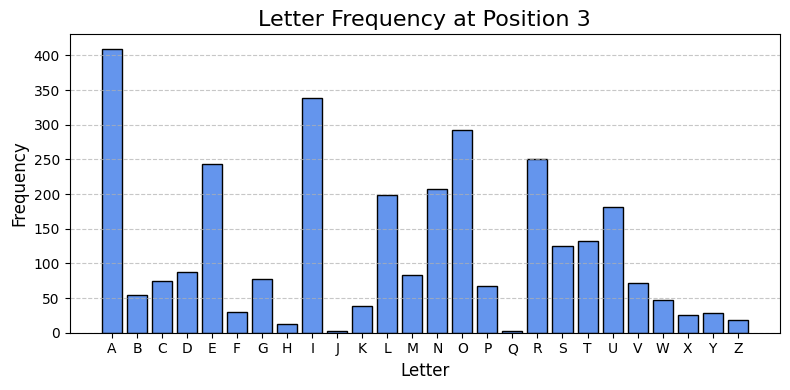

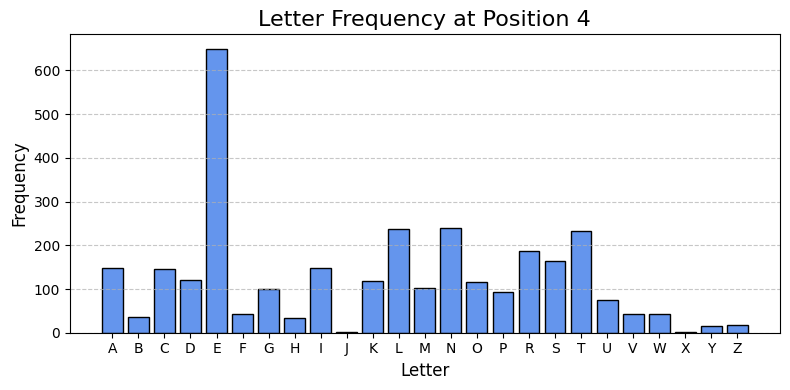

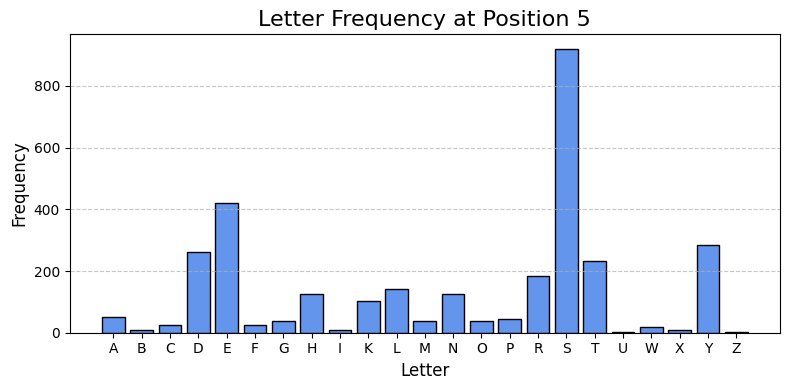

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from typing import Tuple
import numpy as np
import random
import cvxpy as cp
from tqdm import tqdm


# Load the wordlist
wordlist_path = 'wordlist.csv'  # Update the path if needed
wordlist_df = pd.read_csv(wordlist_path, header=None, names=["word"])

# Clean up whitespace and ensure strings
wordlist_df["word"] = wordlist_df["word"].astype(str).str.strip()
wordlist = wordlist_df["word"].tolist()

# Print total number of words
print(f"Total words loaded: {len(wordlist)}")

# Prepare data for each letter position (1–5)
positions = [[] for j in range(5)]
for word in wordlist:
    for i, char in enumerate(word):
        positions[i].append(char)

# Plot a separate histogram for each position
for i, pos_chars in enumerate(positions):
    counter = Counter(pos_chars)
    sorted_items = sorted(counter.items())  # Alphabetical order
    letters, frequencies = zip(*sorted_items)

    plt.figure(figsize=(8, 4))
    plt.bar(letters, frequencies, color='cornflowerblue', edgecolor='black')
    plt.title(f'Letter Frequency at Position {i + 1}', fontsize=16)
    plt.xlabel('Letter', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [4]:
def wordle_feedback(solution: str, guess: str) -> Tuple[int, int, int]:
    """
    Compare guess to solution and return the number of green, yellow, and gray tiles.
    - Green: correct letter and correct position
    - Yellow: correct letter, wrong position
    - Gray: letter not in the word
    """
    green = 0
    yellow = 0

    solution_chars = list(solution)
    guess_chars = list(guess)
    used = [False] * 5  # Track matched characters in solution

    # First pass: match greens
    for i in range(5):
        if guess_chars[i] == solution_chars[i]:
            green += 1
            used[i] = True
            guess_chars[i] = None  # Mark as matched

    # Second pass: match yellows
    for i in range(5):
        if guess_chars[i] is not None:
            for j in range(5):
                if not used[j] and guess_chars[i] == solution_chars[j]:
                    yellow += 1
                    used[j] = True
                    break

    gray = 5 - (green + yellow)
    return green, yellow, gray

# Test cases
print("Feedback for CRANE vs SLATE:", wordle_feedback("SLATE", "CRANE"))
print("Feedback for BRAIN vs BRINE:", wordle_feedback("BRINE", "BRAIN"))



Feedback for CRANE vs SLATE: (2, 0, 3)
Feedback for BRAIN vs BRINE: (2, 2, 1)


In [5]:
# Set the seed for reproducibility
np.random.seed(42)

# Simulation function
def estimate_probability(wordlist, guess_word, condition_fn, trials=1000):
    count = 0
    for i in range(trials):
        solution = random.choice(wordlist)
        green, yellow, gray = wordle_feedback(solution, guess_word)
        if condition_fn(green, yellow, gray):
            count += 1
    return count / trials

# Define conditions
def at_least_one_green(g, y, r): return g >= 1
def exactly_two_yellow(g, y, r): return y == 2

# Run simulations
guess_word = "CRANE"
p_green = estimate_probability(wordlist, guess_word, at_least_one_green)
p_two_yellow = estimate_probability(wordlist, guess_word, exactly_two_yellow)

# Display results
print(f"Estimated P(at least one green tiles | {guess_word}): {p_green:.4f}")
print(f"Estimated P(exactly two yellow tiles | {guess_word}): {p_two_yellow:.4f}")


Estimated P(at least one green tiles | CRANE): 0.4160
Estimated P(exactly two yellow tiles | CRANE): 0.2340


In [6]:
def is_consistent(candidate, guess, feedback):
    return wordle_feedback(candidate, guess) == feedback

def greedy_solver(initial_guess: str, wordlist: list, trials: int = 1000) -> float:
    total_steps = 0
    random.seed(42)  # for reproducibility

    for i in range(trials):
        solution = random.choice(wordlist)
        candidates = wordlist.copy()
        guess_word = initial_guess  #  Reset the guess at the start of each trial
        steps = 0

        while True:
            steps += 1
            feedback = wordle_feedback(solution, guess_word)
            if feedback[0] == 5:
                break
            # Filter words consistent with feedback
            candidates = [w for w in candidates if is_consistent(w, guess_word, feedback)]
            guess_word = random.choice(candidates) if candidates else random.choice(wordlist)

        total_steps += steps

    return total_steps / trials


In [7]:
avg_steps_crane = greedy_solver("CRANE", wordlist)
avg_steps_verve = greedy_solver("VERVE", wordlist)

print(f"Average steps to guess using CRANE: {avg_steps_crane:.4f}")
print(f"Average steps to guess using VERVE: {avg_steps_verve:.4f}")


Average steps to guess using CRANE: 5.2580
Average steps to guess using VERVE: 5.4650


In [10]:
np.random.seed(42)

# Define conditions
def at_least_one_green(g, y, r): return g >= 1
def exactly_two_yellow(g, y, r): return y == 2

# Estimate for all words
green_probs = []
yellow2_probs = []

for word in tqdm(wordlist, desc="Estimating probabilities"):
    p_green = estimate_probability(wordlist, word, at_least_one_green)
    p_yellow2 = estimate_probability(wordlist, word, exactly_two_yellow)
    green_probs.append(p_green)
    yellow2_probs.append(p_yellow2)

green_probs = np.array(green_probs)
yellow2_probs = np.array(yellow2_probs)

# S1: Max P(at least one green)
idx_s1 = np.argmax(green_probs)
print(f"S1 strategy: word = {wordlist[idx_s1]}, P(at least one green) = {green_probs[idx_s1]:.4f}")

# S2: Max P(exactly two yellow)
idx_s2 = np.argmax(yellow2_probs)
print(f"S2 strategy: word = {wordlist[idx_s2]}, P(exactly two yellow) = {yellow2_probs[idx_s2]:.4f}")

# S3: Optimize α using cvxpy (DCP-compliant formulation)
alpha = cp.Variable()
t = cp.Variable()
constraints = [
    t <= alpha * green_probs[i] + (1 - alpha) * yellow2_probs[i]
    for i in range(len(wordlist))
]
constraints += [alpha >= 0, alpha <= 1]
objective = cp.Maximize(t)
problem = cp.Problem(objective, constraints)
problem.solve()

alpha_star = alpha.value
combo_vals = alpha_star * green_probs + (1 - alpha_star) * yellow2_probs
idx_s3 = np.argmin(combo_vals)

print(f"S3 strategy:")
print(f"  Optimal alpha* = {alpha_star:.4f}")
print(f"  Chosen word = {wordlist[idx_s3]}")
print(f"  Combined score = {combo_vals[idx_s3]:.4f}")



Estimating probabilities: 100%|██████████| 3103/3103 [00:25<00:00, 122.17it/s]


S1 strategy: word = SOLES, P(at least one green) = 0.6330
S2 strategy: word = ASIDE, P(exactly two yellow) = 0.3700
S3 strategy:
  Optimal alpha* = 0.9259
  Chosen word = AFFIX
  Combined score = 0.1078
